# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.0 MB/s 


## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
!unzip "/content/drive/MyDrive/Spiral.zip" -d "/content/"

Archive:  /content/drive/MyDrive/Spiral.zip
   creating: /content/Spiral/Healthy/
  inflating: /content/Spiral/Healthy/Healthy_original_sp1-H1.jpg_81b76f15-d685-4237-9897-772b41ecb57f.jpg  
  inflating: /content/Spiral/Healthy/Healthy_original_sp1-H1.jpg_829b4a5d-666d-4af8-a816-33f9f3886405.jpg  
  inflating: /content/Spiral/Healthy/Healthy_original_sp1-H1.jpg_b298b864-681c-4205-ab7c-3574447ab01a.jpg  
  inflating: /content/Spiral/Healthy/Healthy_original_sp1-H1.jpg_e67d58be-d4a5-41ef-b3cc-f9f8f9eafc77.jpg  
  inflating: /content/Spiral/Healthy/Healthy_original_sp1-H10.jpg_19411e7b-8d5f-4914-979a-643ee9c1287c.jpg  
  inflating: /content/Spiral/Healthy/Healthy_original_sp1-H10.jpg_34100d0a-94bf-410e-9d6d-a781a326c3e6.jpg  
  inflating: /content/Spiral/Healthy/Healthy_original_sp1-H10.jpg_3f38e1bf-07fd-4970-a856-ff5fe9c305b0.jpg  
  inflating: /content/Spiral/Healthy/Healthy_original_sp1-H10.jpg_6496b99c-b315-4d06-a688-99f2a8d9abd3.jpg  
  inflating: /content/Spiral/Healthy/Healthy_origi

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
# import numpy as np
import os

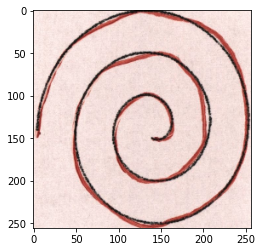

In [ ]:
data_path = '/content/Spiral/'
categories = ['Healthy', 'Patient']
for category in categories:
  path = os.path.join(data_path, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    new_array = cv2.resize(img_array, (256, 256))
    plt.imshow(new_array, cmap='gray')
    # plt.show()
    break
  break

In [ ]:
IMG_SIZE = 64

training_set = []

for category in categories:
  path = os.path.join(data_path, category)
  index = categories.index(category)
  for img in os.listdir(path):
    try:
      img_array = cv2.imread(os.path.join(path, img))
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      training_set.append([new_array, index])
    except Exception as e:
        pass


In [ ]:
import random
random.shuffle(training_set)

In [ ]:
X_train = []
y_train = []

for img_array, label in training_set:
  X_train.append(img_array)
  y_train.append(label)

In [ ]:
X_train =  np.array(X_train).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
y_train = np.array(y_train)

In [ ]:
# X_train = X_train/255.0

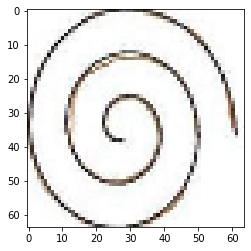

In [ ]:
plt.imshow(X_train[0], cmap='gray')

In [ ]:
X_train.shape

(2000, 64, 64, 3)

In [ ]:
y_train[:5]

array([0, 1, 1, 0, 1])

In [ ]:
y_train = y_train.reshape(-1,1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Prepare the data

In [ ]:
num_classes = 2
input_shape = (64, 64, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (1600, 64, 64, 3) - y_train shape: (1600, 1)
x_test shape: (400, 64, 64, 3) - y_test shape: (400, 1)


## Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        # layers.RandomZoom(
        #     height_factor=0.2, width_factor=0.2
        # ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [ ]:
# x_train[0]

Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


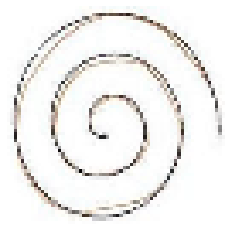

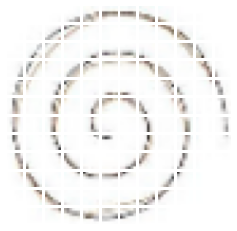

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
180/180 [==============================] - 17s 43ms/step - loss: 2.9236 - accuracy: 0.7111 - val_loss: 0.5407 - val_accuracy: 0.7875
Epoch 2/100
180/180 [==============================] - 6s 34ms/step - loss: 0.7235 - accuracy: 0.7271 - val_loss: 0.4673 - val_accuracy: 0.7188
Epoch 3/100
180/180 [==============================] - 6s 36ms/step - loss: 0.5145 - accuracy: 0.7410 - val_loss: 0.4256 - val_accuracy: 0.8000
Epoch 4/100
180/180 [==============================] - 6s 33ms/step - loss: 0.4553 - accuracy: 0.7833 - val_loss: 0.4038 - val_accuracy: 0.7937
Epoch 5/100
180/180 [==============================] - 6s 34ms/step - loss: 0.4477 - accuracy: 0.7764 - val_loss: 0.4438 - val_accuracy: 0.7812
Epoch 6/100
180/180 [==============================] - 6s 31ms/step - loss: 0.4463 - accuracy: 0.7812 - val_loss: 0.3910 - val_accuracy: 0.8000
Epoch 7/100
180/180 [==============================] - 6s 32ms/step - loss: 0.4414 - accuracy: 0.7778 - val_loss: 0.4020 - val_accuracy

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.